See [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_stringer_spontaneous.ipynb)

In [11]:
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load data
dat = np.load('../data/stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


dat has keys:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [13]:
def svca(Ftrain, Ftest, Gtrain, Gtest, n_dims = None):
    """
    Shared Variance Component Analysis (SVCA, Stringer et al., Science 2019)
    Estimate the dimensionality of neural activity using cross-validation
    across samples and features

    Arguments:
        Ftrain (array): (train samples, neurons set 1)
        Ftest (array):(test samples, neurons set 1)
        Gtrain (array):(train samples, neurons set 2)
        Gtest (array):(test samples, neurons set 2)
        n_dims (int): number of dimensions, default - all dimensions

    Returns:
        array (n_dims, ): reliable variance per dimension
        array (n_dims, ): fraction of reliable variance
        SVC1 (time, n_dims):
        SVC2 (time, n_dims):

    """
    # Test dims
    assert Ftrain.shape[1] == Ftest.shape[1] # neurons set 1
    assert Gtrain.shape[1] == Gtest.shape[1] # neurons set 2
    assert Ftrain.shape[0] == Gtrain.shape[0] # samples
    assert Ftest.shape[0] == Gtest.shape[0] # samples
    if n_dims is None:
        n_dims = min(Ftrain.shape[1], Gtrain.shape[1])
    # Compute train and test covariance
    Ttrain = Ftrain.shape[0]
    Ttest = Ftest.shape[0]
    Ctrain = Ftrain.T @ Gtrain / Ttrain  # N_train x N_test
    Ctest = Ftest.T @ Gtest / Ttest
    # SVD of test covariance to find bases
    U, _, Vh = svd(Ctrain)
    # Test variance within groups
    C_F = Ftest.T @ Ftest / Ttest #N_F x N_F
    C_G = Gtest.T @ Gtest / Ttest
    # Project onto bases
    S_hat = U[:,:n_dims].T @ Ctest @ Vh[:n_dims].T
    S_F = U[:,:n_dims].T @ C_F @ U[:,:n_dims] # test var - one set of neurons
    S_G = Vh[:n_dims] @ C_G @ Vh[:n_dims].T # the other
    reliable_variance = np.diag(S_hat)
    all_variance = (0.5 * np.diag(S_F + S_G))
    normalized_variance = reliable_variance / all_variance
    SVC1 = Ftest @ U[:,:n_dims] # (time, neurons) * (neurons, pcs)
    SVC2 = Gtest @ Vh[:n_dims].T

    return reliable_variance, all_variance, normalized_variance, SVC1, SVC2

In [14]:
def split_data(X, position, bin_width = None, neuron_bins = 16, time_bins = 60, shuffle = False, seed = None):
    """
    Split data along time/observation and neuron/feature axes

    Arguments:
        X (array): observations (time bins) x features (neurons)
        position (array): position of each neuron - should be x or y direction
        bin_width (float): width (same units as position) of bins in
            which to divide neurons. If None - use neuron_bins
        neuron_bins (int): number of bins/strips - only used when bin width is None
        time_bins (int): width (same units as time axis) of time bins
        shuffle (bool): shuffle observations for each neuron

    Returns:
        Ftrain (train samples, neurons set 1)
        Ftest (test samples, neurons set 1)
        Gtrain (train samples, neurons set 2)
        Gtest (test samples, neurons set 2)
    """
    time_steps, neurons = X.shape
    if shuffle: # Randomly permute each neuron
        rng = np.random.RandomState(seed)
        #X = rng.permutation(X, axis=0)
        n_neurons = X.shape[1]
        for i in range(neurons):
            X[:,i] = np.random.permutation(X[:,i])
        print("Shuffling done")
    # 1. Split neurons
    if bin_width is None:
        bin_width = (position.max() - position.min()) / neuron_bins
    # Create bins spanning spatial positions
    bins = np.arange(position.min(), position.max()+bin_width, bin_width)
    # Combine neurons into alternating even/odd groups
    neuron_id = np.digitize(position, bins) % 2 == 0 # assign alternating bins to same group
    # Split observations (time) in alternating bins of
    split_id = np.ones((2*time_bins,)) # Index for first 2 alternating bins
    split_id[:time_bins] = 0
    # Extend to include all observations
    n_reps = np.round(time_steps/(2*time_bins)) +1
    time_id = np.tile(split_id, int(n_reps))[:time_steps]
    # Now we can split
    Ftrain = X[time_id == 0][:,neuron_id]
    Ftest = X[time_id == 1][:,neuron_id]
    Gtrain = X[time_id == 0][:,~neuron_id]
    Gtest = X[time_id == 1][:,~neuron_id]
    # Center each neuron
    mu_F = Ftrain.mean(0, keepdims=True)
    Ftrain -= mu_F
    Ftest -= mu_F
    mu_G = Gtrain.mean(0, keepdims=True)
    Gtrain -= mu_G
    Gtest -= mu_G

    return Ftrain, Ftest, Gtrain, Gtest

In [15]:
def svca0(X, position, n_dims = None, bin_width = None, neuron_bins = 16, time_bins = 60, shuffle = False, seed = None):
    """
    Shared Variance Component Analysis (SVCA, Stringer et al., Science 2019)
    Estimate the dimensionality of neural activity using cross-validation
    across samples and features

    Arguments:
        X (array): observations (time bins) x features (neurons)
        position (array): position of each neuron - should be x or y direction
        n_dims (int): number of dimensions, default - all dimensions
        bin_width (float): width (same units as position) of bins in
            which to divide neurons. If None - use neuron_bins
        neuron_bins (int): number of bins/strips - only used when bin width is None
        time_bins (int): width (same units as time) of time bins
        shuffle (bool): shuffle observations for each neuron

    Returns:
        array (n_dims, ): variance per dimension
        array (n_dims, ): fraction of reliable variance per dimension

    """
    time_steps, neurons = X.shape
    if shuffle: # Randomly permute each neuron
        rng = np.random.RandomState(seed)
        n_neurons = X.shape[1]
        for i in range(neurons):
            X[:,i] = np.random.permutation(X[:,i])
        print("Shuffling done")
    if n_dims is None:
        n_dims = neurons
    # 1. Split neurons
    if bin_width is None:
        bin_width = (position.max() - position.min()) / neuron_bins
    bins = np.arange(position.min(), position.max()+bin_width, bin_width)
    neuron_id = np.digitize(position, bins) % 2 == 0 # assign alternating bins to same group
    # Split observations (time) in alternating bins of
    split_id = np.ones((2*time_bins,)) # Index for first 2 alternating bins
    split_id[:time_bins] = 0
    # Extend to include all observations
    n_reps = np.round(time_steps/(2*time_bins)) +1
    time_id = np.tile(split_id, int(n_reps))[:time_steps]
    # Now we can split
    Ftrain = X[time_id == 0][:,neuron_id]
    Ftest = X[time_id == 1][:,neuron_id]
    Gtrain = X[time_id == 0][:,~neuron_id]
    Gtest = X[time_id == 1][:,~neuron_id]
    # Center each neuron
    mu_F = Ftrain.mean(0, keepdims=True)
    Ftrain -= mu_F
    Ftest -= mu_F
    mu_G = Gtrain.mean(0, keepdims=True)
    Gtrain -= mu_G
    Gtest -= mu_G
    # 2. Compute train and test covariance
    Ttrain = Ftrain.shape[0]
    Ttest = Ftest.shape[0]
    Ctrain = Ftrain.T @ Gtrain / Ttrain  # N_train x N_test
    Ctest = Ftest.T @ Gtest / Ttest
    # 3. SVD of test covariance to find bases
    U, _, Vh = svd(Ctrain)
    # Test variance within groups
    C_F = Ftest.T @ Ftest / Ttest #N_F x N_F
    C_G = Gtest.T @ Gtest / Ttest
    # Project onto bases
    S_hat = U[:,:n_dims].T @ Ctest @ Vh[:n_dims].T
    S_F = U[:,:n_dims].T @ C_F @ U[:,:n_dims] # test var - one set of neurons
    S_G = Vh[:n_dims] @ C_G @ Vh[:n_dims].T # the other
    reliable_variance = np.diag(S_hat)
    all_variance = (0.5 * np.diag(S_F + S_G))
    normalized_variance = reliable_variance / all_variance
    SVC1 = Ftest @ U[:,:n_dims] # (time, neurons) * (neurons, pcs)
    SVC2 = Gtest @ Vh[:n_dims].T

    return reliable_variance, all_variance, normalized_variance, SVC1, SVC2

From the paper:

* The first 128 SVCs together accounted for 86 ± 1% SE of the complete population’s reliable variance,
* 67 ± 3% SE of the total variance in these 128 dimensions was reliable. 
* The fraction of reliable variance in the first SVC was 97%, the 50th SVC at ~50% reliable variance and the 512th at ~9%.


% of reliable variance in SVCs1-128: 86.85%
% of variance SVCs1-128 is reliable: 74.85%
Reliable var SVC1: 96.72%
Reliable var SVC128: 56.41%
Reliable var SVC128: 6.93%


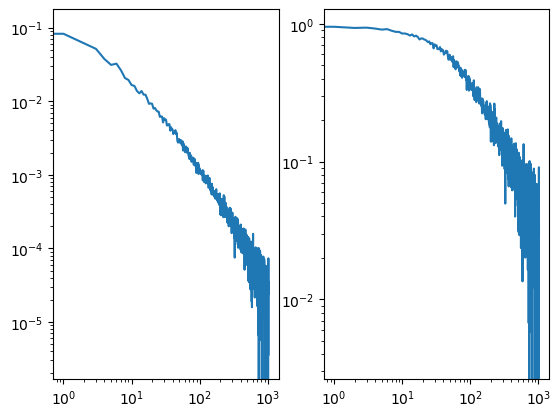

In [16]:
Ftrain, Ftest, Gtrain, Gtest = split_data(dat['sresp'].copy().T, dat['xyz'][0], bin_width=60)
reliable_variance, all_variance, normalized_variance, SVC1, SVC2 = svca(Ftrain, Ftest, Gtrain, Gtest, n_dims=1024)
fig, ax = plt.subplots(1, 2)

ax[0].loglog(reliable_variance / np.sum(reliable_variance))
ax[1].loglog(normalized_variance)


print(f"% of reliable variance in SVCs1-128: {np.sum(reliable_variance[:128]) / np.sum(reliable_variance)*100:0.2f}%") # 86
print(f"% of variance SVCs1-128 is reliable: {np.sum(reliable_variance[:128]) / np.sum(all_variance[:128])*100:0.2f}%") # 67%?
print(f"Reliable var SVC1: {normalized_variance[0]*100:0.2f}%")
print(f"Reliable var SVC128: {normalized_variance[49]*100:0.2f}%") # 50% in the data?
print(f"Reliable var SVC128: {normalized_variance[511]*100:0.2f}%") # 9% in the data?

In [17]:
reliable_variance.shape

(1024,)

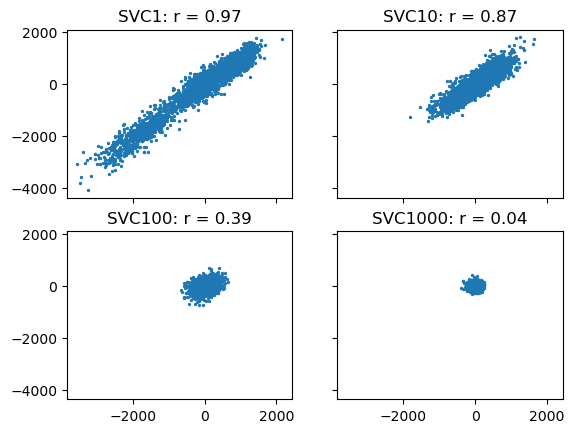

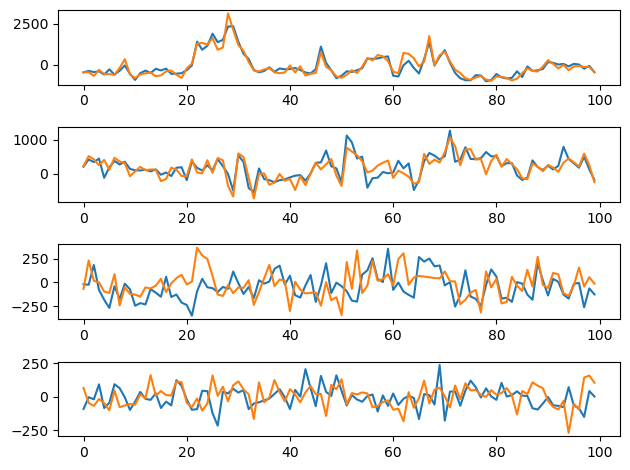

In [18]:
s = 2
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0,0].scatter(SVC1[:,0], SVC2[:,0], s=s)
ax[0,0].set_title(f"SVC1: r = {np.corrcoef(SVC1[:,0], SVC2[:,0])[0,1]:0.2f}")
ax[0,1].scatter(SVC1[:,9], SVC2[:,9], s=s)
ax[0,1].set_title(f"SVC10: r = {np.corrcoef(SVC1[:,9], SVC2[:,9])[0,1]:0.2f}")
ax[1,0].scatter(SVC1[:,99], SVC2[:,99], s=s)
ax[1,0].set_title(f"SVC100: r = {np.corrcoef(SVC1[:,99], SVC2[:,99])[0,1]:0.2f}")
ax[1,1].scatter(SVC1[:,990], SVC2[:,999], s=s)
ax[1,1].set_title(f"SVC1000: r = {np.corrcoef(SVC1[:,999], SVC2[:,999])[0,1]:0.2f}")

fig, ax = plt.subplots(4, 1)
for i, p in enumerate([0, 9, 99, 999]):
    ax[i].plot(-SVC1[:100,p])
    ax[i].plot(-SVC2[:100,p])
fig.tight_layout()

In [19]:
fig, ax = plt.subplots(1, 2)

reliable_variance, all_variance, normalized_variance, SVC1, SVC2 = svca0(dat['sresp'].copy().T, dat['xyz'][0], n_dims=1024, bin_width=60)
ax[0].loglog(reliable_variance)
ax[1].loglog(normalized_variance)
print(f"% of reliable variance in SVCs1-128: {np.sum(reliable_variance[:128]) / np.sum(reliable_variance)*100:0.2f}%") # 86
print(f"% of variance SVCs1-128 is reliable: {np.sum(reliable_variance[:128]) / np.sum(all_variance[:128])*100:0.2f}%") # 67%?
print(f"Reliable var SVC1: {normalized_variance[0]*100:0.2f}%")
print(f"Reliable var SVC128: {normalized_variance[49]*100:0.2f}%") # 50% in the data?
print(f"Reliable var SVC128: {normalized_variance[511]*100:0.2f}%") # 9% in the data?

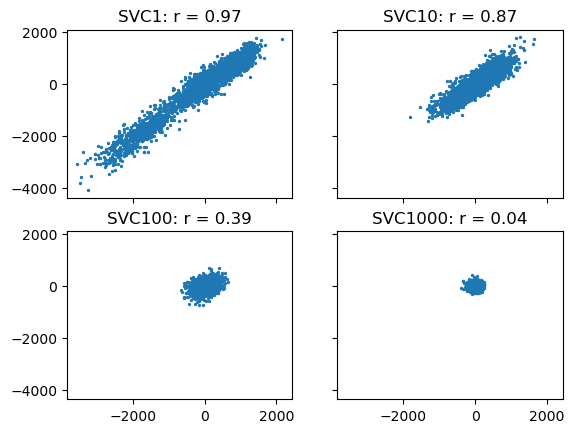

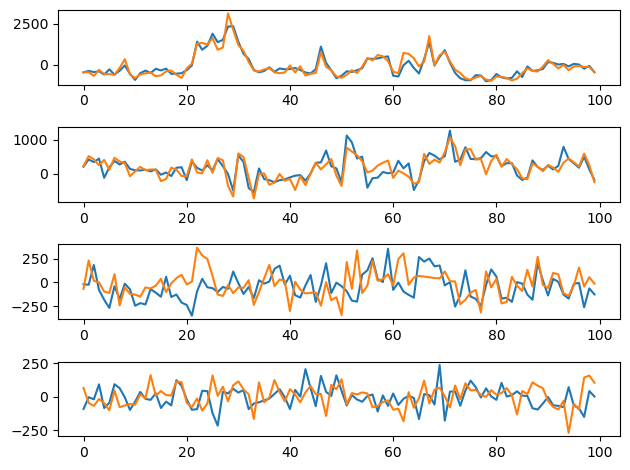

In [ ]:
s = 2
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0,0].scatter(SVC1[:,0], SVC2[:,0], s=s)
ax[0,0].set_title(f"SVC1: r = {np.corrcoef(SVC1[:,0], SVC2[:,0])[0,1]:0.2f}")
ax[0,1].scatter(SVC1[:,9], SVC2[:,9], s=s)
ax[0,1].set_title(f"SVC10: r = {np.corrcoef(SVC1[:,9], SVC2[:,9])[0,1]:0.2f}")
ax[1,0].scatter(SVC1[:,99], SVC2[:,99], s=s)
ax[1,0].set_title(f"SVC100: r = {np.corrcoef(SVC1[:,99], SVC2[:,99])[0,1]:0.2f}")
ax[1,1].scatter(SVC1[:,990], SVC2[:,999], s=s)
ax[1,1].set_title(f"SVC1000: r = {np.corrcoef(SVC1[:,999], SVC2[:,999])[0,1]:0.2f}")

fig, ax = plt.subplots(4, 1)
for i, p in enumerate([0, 9, 99, 999]):
    ax[i].plot(-SVC1[:100,p])
    ax[i].plot(-SVC2[:100,p])
fig.tight_layout()